In [7]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [8]:
import cython
import numpy as np
import time
from cython.parallel import prange , parallel
from cython import nogil
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mplt
import cartopy.crs as ccrs
from cartopy import config

**Dataset and variables**

In [16]:
A = np.genfromtxt( 'Stokes_Coeffs.txt' )

N , M , C , S = A[:,0] , A[:,1] , A[:,2] , A[:,3]

GM = 3986004.415e8 # m^3/s^2
r_Earth = 6378137 # m

n_max = 100
print( 'Number of coefficients: ' , n_max )

save = False

# ------------------ ORBITAL PARAMETERS ------------------------------

Omega = np.deg2rad(60) # rad
i = np.deg2rad(50)
e = 0.02
omega = np.deg2rad(90)
a = 1e7 + r_Earth #m 

f = 0 #rad 

r = a*( 1. - e**2 )/( 1. + e*np.cos(f) )

Period = 2*np.pi*np.sqrt( ( a**3 )/GM ) # s

nn = np.sqrt( GM/a**3 )

IC = np.zeros( 6 )

# -------------------- INITIAL CONDITIONS -----------------------------

IC[0] = r*( np.cos(Omega)*np.cos(omega+f) - np.sin(Omega)*np.sin(omega+f)*np.cos(i) )
IC[1] = r*( np.sin(Omega)*np.cos(omega+f) + np.cos(Omega)*np.sin(omega+f)*np.cos(i) )
IC[2] = r*np.sin(omega+f)*np.sin(i)

IC[3] = -(nn*a/np.sqrt(1-e**2))*( ( np.sin(omega+f) + e*np.sin(omega) )*np.cos(Omega) 
                                 + ( np.cos(omega+f) + e*np.cos(omega) )*np.sin(Omega)*np.cos(i) )
IC[4] = -(nn*a/np.sqrt(1-e**2))*( ( np.sin(omega+f) + e*np.sin(omega) )*np.sin(Omega) 
                                 - ( np.cos(omega+f) + e*np.cos(omega) )*np.cos(Omega)*np.cos(i) )
IC[5] = (nn*a/np.sqrt(1-e**2))*( np.cos(omega+f) + e*np.cos(omega) )*np.sin(i)

# ----------------------- SHOW OF THE KEPLERIAN PARAMETERS -----------------------------

print('i = ' , np.rad2deg(i) , 'deg')
print('Omega = ' , np.rad2deg(Omega) , 'deg')
print('omega = ' , np.rad2deg(omega) , 'deg')
print('e = ' , e)
print('a = ' , a/1e3 , 'km')
print('f_0 = ' , np.rad2deg(f) , 'deg')
print('P = ' , Period/3600 , 'hours')

Number of coefficients:  100
i =  14.999999999999998 deg
Omega =  59.99999999999999 deg
omega =  270.0 deg
e =  0.01
a =  5000000.0 km
f_0 =  0.0 deg
P =  30907.472136535616 hours


**Coefficeints functions**

In [17]:
def f_coef(n):
    if n == 0:
        return 0.
    elif n == 1:
        return np.sqrt( (2.*n+1.)/n )
    else:
        return np.sqrt( (2.*n+1.)/(2.*n) )
    
def g_coef(n , m):
    if n == m:
        return 0.
    else:
        return np.sqrt( (4.*n**2 - 1.)/(n**2 - m**2) )
    
def h_coef(n , m):
    if n == m:
        return 0.
    else:
        return np.sqrt( ( (2.*n + 1.)*( (n - 1.)**2 - m**2) )/( (2.*n - 3.)*(n**2 - m**2) ) )

def k_coef(n , m):
    if m == 0:
        return np.sqrt( (n - m)*(n + m + 1.)/2. )
    else:
        return np.sqrt( (n - m)*(n + m + 1.) )

print( 'Coefficients Functions, OK!' )

Coefficients Functions, OK!


**Cython functions**

In [18]:
%%cython -f

# distutils: extra_compile_args = /openmp
# distutils: extra_link_args = /openmp
# cython: boundscheck = False

import cython
import numpy as np
cimport numpy as np
cimport openmp
from cython.parallel import prange, parallel, threadid
from libc.stdlib cimport malloc, realloc, free, abort
from libc.math cimport cos , sin , sqrt , tan

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.nonecheck(False)
@cython.cdivision(True)

cdef inline stokes_indices( double [:] N , double [:] M ):

    INDEX = np.zeros( len(N) ) 
    cdef double i , j 
    cdef int ii
    cdef int t1 = len(N)
    cdef int t2 = len(M)

    for ii in prange( t1 , nogil = True , schedule = 'static' , num_threads = 8 ):
        i = N[ii]
        j = M[ii]
        if i == j:
            with gil: INDEX[ii] = ii
    
    return INDEX
  
def CS_IND(double [:] N , double [:] M):
    return stokes_indices(N , M)

#######################################################################

cdef inline double [:,:] SIN_COS( double lam , int n_max ):
    
    cdef int m , n_t
    cdef double [:,:] COS_SIN = np.zeros( (n_max , 2) )
    cdef double L = np.deg2rad(lam)
    cdef double H
    
    for m in prange( n_max , nogil = True , schedule = 'static' , num_threads = 8 ):
        
        H = m*L
        COS_SIN[ m , 0 ] = cos(H)
        COS_SIN[ m , 1 ] = sin(H)
        
    return COS_SIN

def COS_SIN( double lam , int n_max ):
    return SIN_COS( lam , n_max )

#######################################################################

cdef inline double [:,:] LEGENDRE( int n_max , double phi , double [:] F , double [:,:] G , double [:,:] H ):
                             
    cdef int n , m 
    cdef double [:,:] P = np.zeros( ( n_max , n_max ) )
    cdef double c , s

    cdef double Phi = np.deg2rad(phi)

    c = cos(Phi)
    s = sin(Phi)

    P[0,0] = 1.
    P[1,0] = sqrt(3.)*s
    P[1,1] = sqrt(3.)*c

    for m in prange(n_max , nogil = True , schedule = 'static' , num_threads = 8):  
        for n in prange(m+1 , n_max , schedule = 'static' , num_threads = 8):
            P[n,n] = F[n]*c*P[n-1,n-1]
            P[n,m] = G[n,m]*P[n-1,m]*s - H[n,m]*P[n-2,m]

    return P

def ALF( int n_max , double phi , double [:] F , double [:,:] G , double [:,:] H ):
    return LEGENDRE( n_max , phi , F , G , H )

##################################################################################################################

cdef inline double [:,:] dphi_LEGENDRE( int n_max , double phi , double [:,:] P , double [:,:] K ):
                             
    cdef int n , m 
    cdef double [:,:] dP = np.zeros( ( n_max , n_max ) )

    cdef double Phi = np.deg2rad(phi)
    cdef double t = tan(Phi)

    for m in prange(n_max , nogil = True , schedule = 'static' , num_threads = 8):  
        for n in prange(m+1 , n_max , schedule = 'static' , num_threads = 8):
            dP[n,n] = -n*t*P[n,n]
            dP[n,m] = K[n,m]*P[n,m+1] - m*t*P[n,m]

    return dP

def dphi_ALF( int n_max , double phi , double [:,:] P , double [:,:] K ):
    return dphi_LEGENDRE( n_max , phi , P , K )

#################################################################################################################################
######################################## LUMPED COEFFICIENTS FUNCTIONS ##########################################################
#################################################################################################################################

cdef inline double [:,:] Lumped( double r , int n_max , #given parameters and variables
                                   double [:] C , double [:] S , double [:] N ,  #Stokes coefficients and indexes
                                   double [:,:] P ): #ALF

    cdef double Y = ( 6.378137e6 )/r

    cdef int n , n_t , index , m

    cdef double [:,:] Lump = np.zeros( ( 2 , n_max ) )

    cdef double A , B 

    for m in prange( n_max , schedule = 'static' , num_threads = 8 , nogil = True ):

        A , B = 0. , 0.

        for n in prange( 0 , n_max , schedule = 'static' , num_threads = 8 ):

            index = int( N[ n ] - 2 )

            A += P[ n , m ]*C[ index - n + m ]*(Y**n)
            B += P[ n , m ]*S[ index - n + m ]*(Y**n)

        Lump[ 0 , m ] = A # Am
        Lump[ 1 , m ] = B # Bm

    return Lump

def Lumped_py( double r , int n_max , #given parameters and variables
               double [:] C , double [:] S , double [:] N ,  #Stokes coefficients and indexes
               double [:,:] P ): #ALF for every phi value
    return Lumped( r , n_max , C , S , N , P )

#############################################################################################################

cdef inline double [:,:] der_Lumped( double r , int n_max , #given parameters and variables
                                   double [:] C , double [:] S , double [:] N ,  #Stokes coefficients and indexes
                                   double [:,:] P , double [:,:] dP ): #ALF

    cdef double Y = ( 6.378137e6 )/r

    cdef int n , n_t , index , m

    cdef double [:,:] dLump = np.zeros( ( 4 , n_max ) )

    cdef double Ar , Br , Ap , Bp

    for m in prange( n_max , schedule = 'static' , num_threads = 8 , nogil = True ):

        Ar = 0
        Br = 0
        Ap = 0
        Bp = 0

        for n in prange( 0 , n_max , schedule = 'static' , num_threads = 8 ):

            index = int( N[ n ] - 2 )

            Ar += P[ n , m ]*C[ index - n + m ]*(Y**n)*(n+1)
            Br += P[ n , m ]*S[ index - n + m ]*(Y**n)*(n+1)
            Ap += dP[ n , m ]*C[ index - n + m ]*(Y**n)
            Bp += dP[ n , m ]*S[ index - n + m ]*(Y**n)

    dLump[ 0 , m ] = Ar #dA/dr
    dLump[ 1 , m ] = Br #dB/dr
    dLump[ 2 , m ] = Ap #dA/dp
    dLump[ 3 , m ] = Bp #dB/dp

    return dLump

def dLumped_py( double r , int n_max , #given parameters and variables
               double [:] C , double [:] S , double [:] N ,  #Stokes coefficients and indexes
               double [:,:] P , double [:,:] dP ): #ALF for every phi value
    return der_Lumped( r , n_max , C , S , N , P , dP )

#################################################################################################################################
######################################## POTENTIAL FUNCTION #####################################################################
#################################################################################################################################

cdef inline double Calculation( double r , # Variables for V(r,lambda,phi)
                                      int n_max , # Max degree
                                      double [:] COS , double [:] SIN , # cos(m*lambda) and sin(m*lambda)
                                      double [:] A , double [:] B ): # Lumped coefficients
    
    cdef double Pot

    cdef double J = (3986004.415e8)/r # m^2/s^2 -> GM/r

    cdef int m

    cdef double Cor = 0  

    for m in prange( n_max , schedule = 'static' , nogil = True , num_threads = 8 ):
        Cor += A[ m ]*COS[ m ] + B[ m ]*SIN[ m ]

    Pot = J*Cor

    return Pot

def Potential( double r , int n_max , double [:] COS , double [:] SIN , double [:] A , double [:] B ): 
    return Calculation( r , n_max , COS , SIN , A , B )

######################################################################################################################

cdef inline double [:] Nabla_Calculation( double r , # Variables for V(r,lambda,phi)
                              int n_max , # Max degree
                              double [:] COS , double [:] SIN , # cos(m*lambda) and sin(m*lambda)
                              double [:] A , double [:] B , # Lumped coefs
                              double [:] Ar , double [:] Br , # r-derivative of lumped coefs
                              double [:] Ap , double [:] Bp ): # phi-derivative of lumped coefs 
    
    cdef double [:] dPot = np.zeros( 3 )

    cdef double J = 3986004.415e8/r #m^2/s^2
    cdef double dJ = -3986004.415e8/(r**2) #m/s^2

    cdef int m , n_t , index
    cdef double Cor_r = 0
    cdef double Cor_p = 0 
    cdef double Cor_l = 0
    cdef double alpha , beta
      
    for m in prange( n_max , schedule = 'static' , nogil = True , num_threads = 8 ):

        alpha = COS[ m ]
        beta = SIN[ m ]

        Cor_r += alpha*Ar[m] + beta*Br[m]
        Cor_p += alpha*Ap[m] + beta*Bp[m]
        Cor_l += m*( beta*A[m] - alpha*B[m] )

    dPot[ 0 ] = -J*Cor_r/r # dV/dr
    dPot[ 1 ] = J*Cor_p    # dV/dphi
    dPot[ 2 ] = -J*Cor_l   # dV/dlambda
    
    return dPot

def Nabla_Potential(double r , # Variables for V(r,lambda,phi)
                    int n_max , # Max degree
                    double [:] COS , double [:] SIN , # cos(m*lambda) and sin(m*lambda)
                    double [:] A , double [:] B , # Lumped coefs
                    double [:] Ar , double [:] Br , # r-derivative of lumped coefs
                    double [:] Ap , double [:] Bp ): # phi-derivative of lumped coefs
    return Nabla_Calculation( r , n_max , COS , SIN , A , B , Ar , Br , Ap , Bp )

#########################################################################################

cdef inline double [:] dP_cart( double [:] DPot , double lam ,  double phi , double r ):

    cdef double [:] dPot_c = np.zeros(3)

    dPot_c[0] = -(sin(lam)/(r*cos(phi)))*DPot[2] - sin(phi)*cos(lam)*DPot[1]/r + cos(phi)*cos(lam)*DPot[0]
    dPot_c[1] = cos(lam)*DPot[2]/(r*cos(phi)) - sin(phi)*sin(lam)*DPot[1]/r + cos(phi)*sin(lam)*DPot[0]
    dPot_c[2] = cos(phi)*DPot[1]/r + sin(phi)*DPot[0]

    return dPot_c

def dPot_cart( double [:] DPot , double lam ,  double phi , double r ):
    return dP_cart( DPot , lam , phi , r )

#############################################################################################################################

cdef LLc( double x , double y , double z , double h , double Omega , double t , double alpha_GW0 ):

    cdef double [:] LL = np.zeros(2)
    
    LL[0] = np.rad2deg( np.arctan2( z , np.sqrt( x**2 + y**2 ) ) ) # LATITUDE
    LL[1] = np.rad2deg( np.arctan2( y , x ) ) - 0.004165403*t - alpha_GW0 + np.rad2deg(Omega) # LONGITUDE
    
    if LL[1] < -180:
        LL[1] = LL[1] + 360
    if LL[1] > 180:
        LL[1] = LL[1] - 360
        
    return LL

def long_lat_cart( double x , double y , double z , double h , double Omega , double t , double alpha_GW0 ):
    return LLc(x , y , z , h , Omega , t , alpha_GW0)

print( 'Functions OK!' )

Functions OK!


**System evolution functions**

In [19]:
def evolution( t , IC , Grad_Pot ):
    GM = 3986004.415e8 # m^3/s^2
    r = np.linalg.norm(IC[0:3])
    f = np.zeros(6)
    f[0:3] = IC[3:6]
    f[3:6] = Grad_Pot[0:3] - ( GM/(r**3) )*IC[0:3] 
    return f

def RK4( h , t0 , tfin , y0 , n_max , F , G , H , K , C , S , ST_IN , Omega ):  
                                                        
    t = np.arange( t0 , tfin , h )
    y = np.zeros( ( len(t) , len(y0) ) )
    y[0] = y0

    LAM_deg = np.zeros( len(t) )
    PHI_deg = np.zeros( len(t) )

    lam , phi = long_lat_cart( y[0,0] , y[0,1] , y[0,2] , h , Omega , 0 , 100 ) 
    LAM_deg[0] , PHI_deg[0] = lam , phi

    r = np.linalg.norm( y[ 0 , 0:3 ] )

    for i in range( len(t)-1 ):

        lam , phi = np.deg2rad(lam) , np.deg2rad(phi)

        array = COS_SIN( lam , n_max )
        P = ALF( n_max , phi , F , G , H )
        dP = dphi_ALF( n_max , phi , P , K )
        L_Coeffs = Lumped_py( r , n_max , C , S , ST_IN , P )
        DL_Coeffs = dLumped_py( r , n_max , C , S , ST_IN , P , dP )
        DPot = Nabla_Potential( r , n_max , array[:,0] , array[:,1] , L_Coeffs[0,:] , L_Coeffs[1,:] , 
                                DL_Coeffs[0,:] , DL_Coeffs[1,:] , DL_Coeffs[2,:] , DL_Coeffs[3,:] )

        DPot_c = dPot_cart( DPot , lam , phi , r )
        
        T = t[i]
        Y = y[i]

        k1 = evolution( T , Y , DPot_c )
        k2 = evolution( T + 0.5*h , Y + 0.5*h*k1 , DPot_c )
        k3 = evolution( T + 0.5*h , Y + 0.5*h*k2 , DPot_c )
        k4 = evolution( T + h , Y + h*k3 , DPot_c )

        y[i+1] = Y + ( k1 + 2*k2 + 2*k3 + k4 )/6.

        r = np.linalg.norm( y[ i+1 , 0:3 ] )

        LLLL = long_lat_cart( y[i+1,0] , y[i+1,1] , y[i+1,2] , h , Omega , T , 100 ) 
        phi = LLLL[0]
        lam = LLLL[1]
        
        LAM_deg[i+1] = lam
        PHI_deg[i+1] = phi

    return y , LAM_deg , PHI_deg , t

print('Python functions OK!')

Python functions OK!


**Upload data**

In [20]:
t_in = time.perf_counter()

STOKES_INDEX = CS_IND( N , M )
ST_IN = STOKES_INDEX[ STOKES_INDEX != 0 ]

print( 'Stokes coefficients, check!' )

F = np.zeros( n_max )
G = np.zeros( ( n_max , n_max ) )
H = np.zeros( ( n_max , n_max ) )
K = np.zeros( ( n_max , n_max ) )

# f , g , h , k coefficients
for n in range( n_max ):
    F[ n ] = f_coef( n )
    for m in range(n+1):
        G[ n , m ] = g_coef( n , m )
        H[ n , m ] = h_coef( n , m )
        K[ n , m ] = k_coef( n , m )

t_fin = time.perf_counter()

print( "Time for computation = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

print('everything done!')

Stokes coefficients, check!
Time for computation =       0.0695  s
everything done!


In [27]:
### PROVA test part to show the velocity of each function to calculate one value
lam , phi , r = 45 , 45 , 1e8

t_in = time.perf_counter()
array = COS_SIN( lam , n_max )
t_fin = time.perf_counter()

print( "COSSIN = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()
P = ALF( n_max , phi , F , G , H )
t_fin = time.perf_counter()

print( "nALF = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()
dP = dphi_ALF( n_max , phi , P , K )
t_fin = time.perf_counter()

print( "d_nALF = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()
L_Coeffs = Lumped_py( r , n_max , C , S , ST_IN , P )
t_fin = time.perf_counter()

print( "Am,Bm = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()
DL_Coeffs = dLumped_py( r , n_max , C , S , ST_IN , P , dP )
t_fin = time.perf_counter()

print( "d_Am,d_Bm = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()
DPot = Nabla_Potential( r , n_max , array[:,0] , array[:,1] , L_Coeffs[0,:] , L_Coeffs[1,:] , 
                        DL_Coeffs[0,:] , DL_Coeffs[1,:] , DL_Coeffs[2,:] , DL_Coeffs[3,:] )
t_fin = time.perf_counter()

print( "NABLA_V (spherical) = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()
DPot_c = dPot_cart( DPot , lam , phi , r )
t_fin = time.perf_counter()

print( "Nabla_V (cartesian) = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

COSSIN =       0.0005  s
nALF =       0.0004  s
d_nALF =       0.0003  s
Am,Bm =       0.0019  s
d_Am,d_Bm =       0.0003  s
NABLA_V (spherical) =       0.0002  s
Nabla_V (cartesian) =       0.0001  s


In [30]:
# ----------------------------- INITIAL GT POINT ------------------------------------

h = 0.1 # s

LLL = long_lat_cart( IC[0] , IC[1] , IC[2] , 0 , Omega , 0 , 100 )

lam = LLL[1] 
phi = LLL[0]

print( '(lambda,phi,height) di partenza: ' , lam , 'deg , ' , phi , 'deg , ' , (r - r_Earth)/1e3 , 'km' )

# ------------------- INITIAL DISTANCE AND VELOCITY --------------------------------

print('r_0 = ' , np.linalg.norm(IC[0:3])/1e3 , ' km')
print('v_0 = ' , np.linalg.norm(IC[3:6])/1e3 , ' km/s')

# ---------------------------- CALCULATION -------------------------------------

t_in = time.perf_counter()
state , LAM , PHI , t = RK4( h , 0 , 86400 , IC , n_max , F , G , H , K , C , S , ST_IN , Omega )
t_fin = time.perf_counter()

print( "Time for computation = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

(lambda,phi,height) di partenza:  -70.00000000000003 deg ,  -15.000000000000002 deg ,  93621.863 km
r_0 =  4950000.0  km
v_0 =  0.28518519445150625  km/s
Time for computation =     464.4936  s


**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

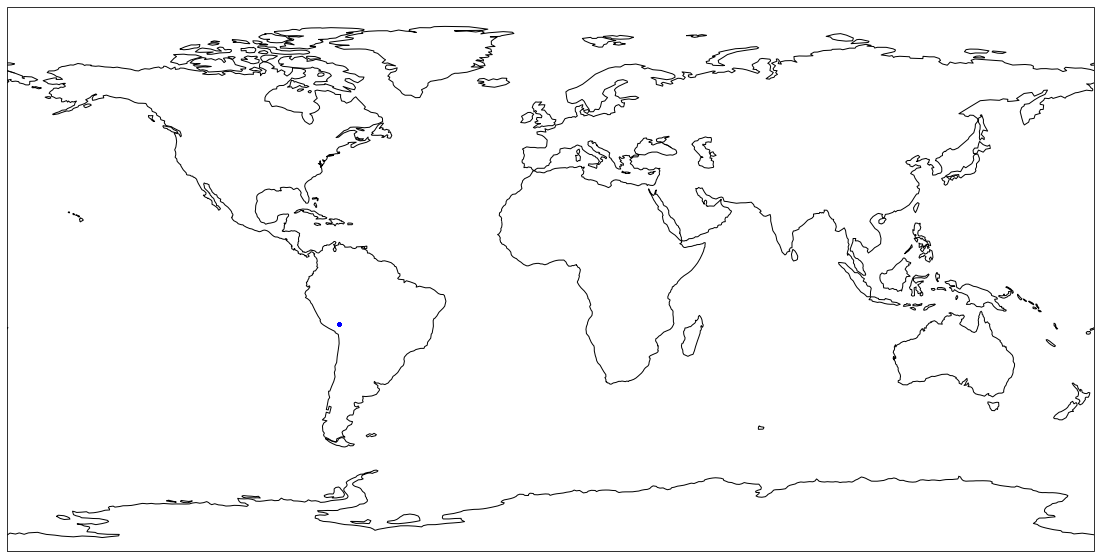

In [31]:
plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

ax.coastlines()
ax.set_xlabel( '$\lambda$ [deg]' )
ax.set_ylabel( '$\phi$ [deg]' )

plt.xlim( -180,180 )
plt.ylim( -90,90 )

plt.plot( LAM[1:len(LAM)-2] , PHI[1:len(LAM)-2] , 'b.' )

if save == True:
    plt.savefig('ORBIT_tundra_n240.png')

plt.show()

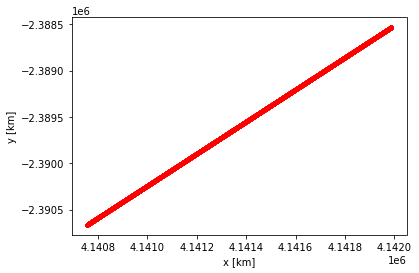

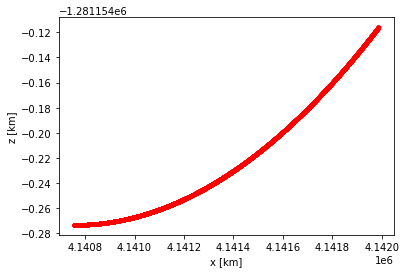

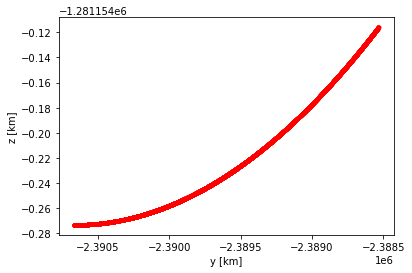

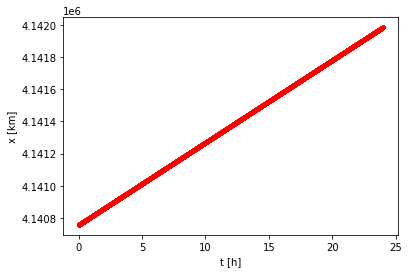

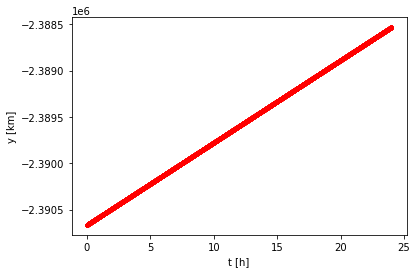

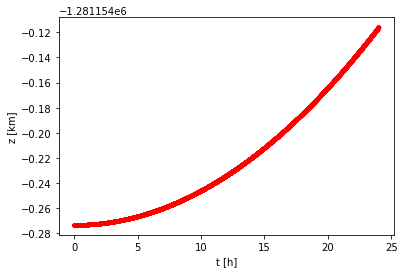

In [24]:
plt.plot(state[:,0]*1e-3 , state[:,1]*1e-3 , 'r.')
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show()

plt.plot(state[:,0]*1e-3 , state[:,2]*1e-3 , 'r.')
plt.xlabel('x [km]')
plt.ylabel('z [km]')
plt.show()

plt.plot(state[:,1]*1e-3 , state[:,2]*1e-3 , 'r.')
plt.xlabel('y [km]')
plt.ylabel('z [km]')
plt.show()

#----------------------------------------

plt.plot(t/3600 , state[:,0]*1e-3 , 'r.')
plt.ylabel('x [km]')
plt.xlabel('t [h]')
plt.show()

plt.plot(t/3600 , state[:,1]*1e-3 , 'r.')
plt.ylabel('y [km]')
plt.xlabel('t [h]')
plt.show()

plt.plot(t/3600 , state[:,2]*1e-3 , 'r.')
plt.ylabel('z [km]')
plt.xlabel('t [h]')
plt.show()